# Setup

In [1]:
# import all required packages
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
processed_data_path = '/content/drive/MyDrive/Folsom_sky_images/processed_data.csv'
irradiance_data = pd.read_csv(processed_data_path)
irradiance_data.head()

,timeStamp,ghi,Year,Month,Day,Hour,Minute,dwsw,cloud_cover,precipitation,...,ENT(G),AVG(B),STD(B),ENT(B),AVG(RB),STD(RB),ENT(RB),AVG(NRB),STD(NRB),ENT(NRB)
0,2014-01-02 08:00:00,0.0,2014.0,1.0,2.0,8.0,0.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
1,2014-01-02 08:01:00,0.0,2014.0,1.0,2.0,8.0,1.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
2,2014-01-02 08:02:00,0.0,2014.0,1.0,2.0,8.0,2.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
3,2014-01-02 08:03:00,0.0,2014.0,1.0,2.0,8.0,3.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882
4,2014-01-02 08:04:00,0.0,2014.0,1.0,2.0,8.0,4.0,0.0,2.0,0.0,...,5.3735,155.943,24.4446,5.1713,1.0168,0.0989,3.7791,0.0062,0.0439,2.882


In [3]:
irradiance_data.shape

(1551888, 34)

In [4]:
irradiance_data.columns

Index(['timeStamp', 'ghi', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'dwsw',
       'cloud_cover', 'precipitation', 'pressure', 'wind-u', 'wind-v',
       'temperature', 'rel_humidity', 'cloud_cover_ratio',
       'satellite_image_AVG', 'satellite_image_STD', 'satellite_image_ENT',
       'AVG(R)', 'STD(R)', 'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)', 'AVG(B)',
       'STD(B)', 'ENT(B)', 'AVG(RB)', 'STD(RB)', 'ENT(RB)', 'AVG(NRB)',
       'STD(NRB)', 'ENT(NRB)'],
      dtype='object')

# Split Data into Training and Testing Sets

In [5]:
column_indices = {name: i for i, name in enumerate(irradiance_data.columns)}

irradiance_data = irradiance_data.drop(["timeStamp"],axis=1)

train_df = irradiance_data[irradiance_data.Year <= 2015]
test_df = irradiance_data[irradiance_data.Year == 2016]

X_train = train_df.drop(["Year","ghi"],axis=1)
Y_train = pd.DataFrame(train_df.loc[:,"ghi"])

X_test = test_df.drop(["Year","ghi"],axis=1)
Y_test = pd.DataFrame(test_df.loc[:,"ghi"])

In [6]:
X_train.columns

Index(['Month', 'Day', 'Hour', 'Minute', 'dwsw', 'cloud_cover',
       'precipitation', 'pressure', 'wind-u', 'wind-v', 'temperature',
       'rel_humidity', 'cloud_cover_ratio', 'satellite_image_AVG',
       'satellite_image_STD', 'satellite_image_ENT', 'AVG(R)', 'STD(R)',
       'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)', 'AVG(B)', 'STD(B)', 'ENT(B)',
       'AVG(RB)', 'STD(RB)', 'ENT(RB)', 'AVG(NRB)', 'STD(NRB)', 'ENT(NRB)'],
      dtype='object')

In [7]:
X_train.shape

(1029600, 31)

In [8]:
X_test.shape

(522288, 31)

# Normalize the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaler = scaler.fit_transform(X_train.values)
X_test_scaler = scaler.transform(X_test.values)

# Data Lags
forecast irradiance (GHI) with 30 minute horizon and one minute granularity (IE, predicting t+1, t+2, t+3…, t+30).

#### preprocess dataset




In [10]:
trainX = np.reshape(X_train_scaler, (X_train_scaler.shape[0], 1, X_train_scaler.shape[1]))
testX = np.reshape(X_test_scaler, (X_test_scaler.shape[0], 1, X_test_scaler.shape[1]))

In [11]:
!pip install GPyOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 929.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=8f0deb37148b530128305cb5a7e84285d1e57f63029f50cad45ddded77886220
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420173 sha256=a28e9d3eb8474a8cd33c82f497394c3ec7f940f911bd80cf8a8e0d6707e43928
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102544 sha256=bce486616d0227700aba3cc

# Build Model

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from GPyOpt.methods import BayesianOptimization
from keras import backend as K

from collections import defaultdict


In [13]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def get_callback(checkpoint_path):
  checkpoint_dir = os.path.dirname("/content/drive/MyDrive/Folsom_sky_images/"+checkpoint_path)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/Folsom_sky_images/"+checkpoint_path,
                                                  save_weights_only=True,
                                                 verbose=1)
  return cp_callback

def get_early_stopping():
  # Define early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',  # Monitor validation loss
      patience=5,           # Stop after no improvement for 5 epochs
      verbose=1,            # Display messages about early stopping
      restore_best_weights=True  # Restore the model weights to the best epoch
  )
  return early_stopping

def get_reduce_learning_rate():
  # Define learning rate reduction callback
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Reduce the learning rate by a factor of 0.2
    patience=3,          # Reduce learning rate if no improvement for 3 epochs
    verbose=1             # Display messages about learning rate reduction
  )
  return reduce_lr

In [14]:
Performance = defaultdict(list)

epochs = 100
batch_size = 3432#int(trainX.shape[0]/epochs) * 0.10
input_shape = (trainX.shape[1], trainX.shape[2])

# Base LSTM

In [15]:
# Define the LSTM model
base_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
base_model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])

checkpoint_path = "base_model/cp.ckpt"

# fit network
base_history = base_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test), callbacks=[get_callback(checkpoint_path)],
                              verbose=2, shuffle=False)


Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/base_model/cp.ckpt
300/300 - 20s - loss: 295.4527 - accuracy: 0.0226 - val_loss: 246.7687 - val_accuracy: 0.0260 - 20s/epoch - 66ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/base_model/cp.ckpt
300/300 - 4s - loss: 140.5233 - accuracy: 0.1707 - val_loss: 104.5284 - val_accuracy: 2.1061e-05 - 4s/epoch - 12ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/base_model/cp.ckpt
300/300 - 2s - loss: 96.4808 - accuracy: 2.2339e-05 - val_loss: 93.4682 - val_accuracy: 2.1061e-05 - 2s/epoch - 6ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/base_model/cp.ckpt
300/300 - 1s - loss: 89.0185 - accuracy: 0.0664 - val_loss: 87.0547 - val_accuracy: 0.0182 - 1s/epoch - 5ms/step
Epoch 5/100

Epoch 5: saving model to /content/drive/MyDrive/Folsom_sky_images/base_model/cp.ckpt
300/300 - 1s - loss: 84.5190 - accurac

In [16]:
test_loss, test_acc = base_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

16322/16322 - 46s - loss: 37.2552 - accuracy: 0.2737 - 46s/epoch - 3ms/step

Test accuracy: 0.27373212575912476


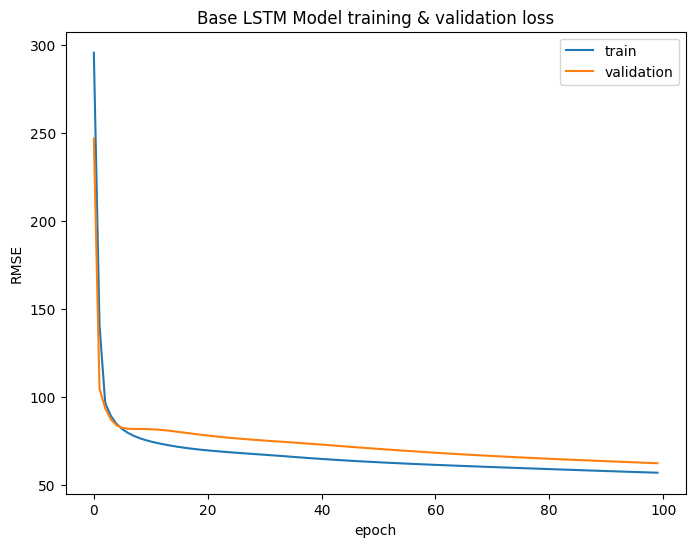

In [17]:
Performance["Model Name"].append("Base LSTM")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# Plot the training and validation losses
plt.plot(base_history.history['loss'], label='train')
plt.plot(base_history.history['val_loss'], label='validation')
plt.title('Base LSTM Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()


# LSTM model with early stopping

Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_model/cp.ckpt
300/300 - 3s - loss: 56.7124 - accuracy: 0.2543 - val_loss: 62.1062 - val_accuracy: 0.2734 - 3s/epoch - 9ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_model/cp.ckpt
300/300 - 2s - loss: 56.6122 - accuracy: 0.2545 - val_loss: 61.9915 - val_accuracy: 0.2736 - 2s/epoch - 6ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_model/cp.ckpt
300/300 - 2s - loss: 56.5125 - accuracy: 0.2548 - val_loss: 61.8785 - val_accuracy: 0.2736 - 2s/epoch - 6ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_model/cp.ckpt
300/300 - 2s - loss: 56.4140 - accuracy: 0.2550 - val_loss: 61.7665 - val_accuracy: 0.2740 - 2s/epoch - 5ms/step
Epoch 5/100

Epoch 5: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_model/cp.ckpt
300/300 - 2s - loss: 56.3170 - accuracy: 0.

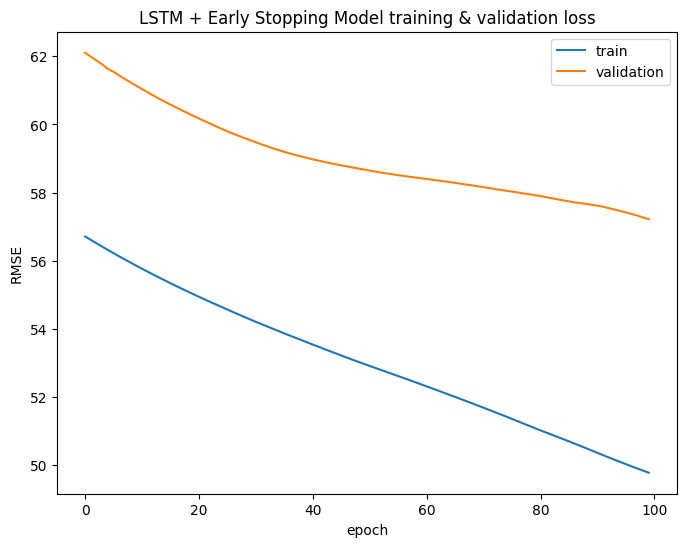

In [18]:
# Base LSTM + Early Stopping
checkpoint_path = "LSTM_ES_model/cp.ckpt"

# fit network
LSTM_ES_history = base_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path)],
                              verbose=2, shuffle=False)

test_loss, test_acc = base_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + Early Stopping")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_history.history['loss'], label='train')
plt.plot(LSTM_ES_history.history['val_loss'], label='validation')
plt.title('LSTM + Early Stopping Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()


# LSTM Model with early stopping and reduce the learning rate

Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_model/cp.ckpt
300/300 - 3s - loss: 49.7142 - accuracy: 0.2697 - val_loss: 57.1658 - val_accuracy: 0.3451 - lr: 0.0010 - 3s/epoch - 11ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_model/cp.ckpt
300/300 - 2s - loss: 49.6537 - accuracy: 0.2697 - val_loss: 57.1109 - val_accuracy: 0.3442 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_model/cp.ckpt
300/300 - 1s - loss: 49.5940 - accuracy: 0.2699 - val_loss: 57.0525 - val_accuracy: 0.3433 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_model/cp.ckpt
300/300 - 2s - loss: 49.5349 - accuracy: 0.2702 - val_loss: 56.9980 - val_accuracy: 0.3426 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/100

Epoch 5: saving model to /content/drive/MyDrive/Folsom_sky_ima

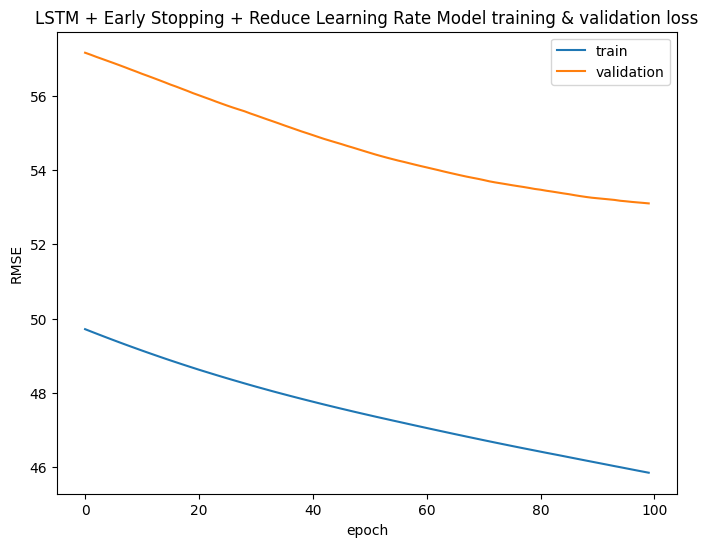

In [19]:
# Base LSTM + Early Stopping + Reduce Learning Rate
checkpoint_path = "LSTM_ES_RLR_model/cp.ckpt"

# fit network
LSTM_ES_RLR_history = base_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path),
                                         get_reduce_learning_rate()],
                              verbose=2, shuffle=False)

test_loss, test_acc = base_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + Early Stopping + Reduce Learning Rate")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_RLR_history.history['loss'], label='train')
plt.plot(LSTM_ES_RLR_history.history['val_loss'], label='validation')
plt.title('LSTM + Early Stopping + Reduce Learning Rate Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# LSTM + Early Stopping + Reduce Learning Rate + Regularization



Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_model/cp.ckpt
300/300 - 6s - loss: 292.7562 - accuracy: 0.0198 - val_loss: 233.8916 - val_accuracy: 0.0173 - lr: 0.0010 - 6s/epoch - 19ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_model/cp.ckpt
300/300 - 2s - loss: 134.9776 - accuracy: 0.2406 - val_loss: 104.4309 - val_accuracy: 2.1061e-05 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_model/cp.ckpt
300/300 - 2s - loss: 96.8969 - accuracy: 2.2339e-05 - val_loss: 93.9626 - val_accuracy: 2.1061e-05 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_model/cp.ckpt
300/300 - 2s - loss: 89.7170 - accuracy: 4.2735e-05 - val_loss: 88.0105 - val_accuracy: 2.1061e-05 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/100

Epoch 5: saving model 

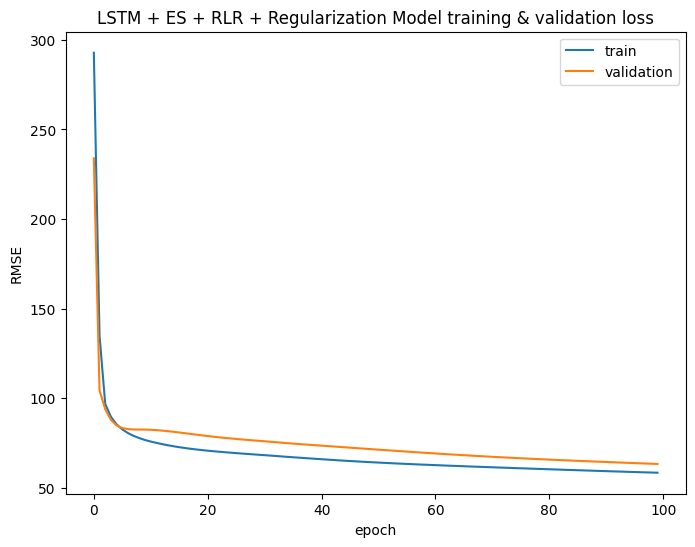

In [20]:
# Define the LSTM + regularizers model
LSTM_ES_RLR_Reg_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

# Compile the model
LSTM_ES_RLR_Reg_model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])

checkpoint_path = "LSTM_ES_RLR_Reg_model/cp.ckpt"

# fit network
LSTM_ES_RLR_Reg_history = LSTM_ES_RLR_Reg_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path),
                                         get_reduce_learning_rate()],
                              verbose=2, shuffle=False)

test_loss, test_acc = LSTM_ES_RLR_Reg_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + ES + RLR + Regularization")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_RLR_Reg_history.history['loss'], label='train')
plt.plot(LSTM_ES_RLR_Reg_history.history['val_loss'], label='validation')
plt.title('LSTM + ES + RLR + Regularization Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()


# LSTM with Early stopping Reduce Learning Rate and Dropout

Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_model/cp.ckpt
300/300 - 6s - loss: 291.8478 - accuracy: 0.0204 - val_loss: 232.4165 - val_accuracy: 0.0212 - lr: 0.0010 - 6s/epoch - 21ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_model/cp.ckpt
300/300 - 2s - loss: 137.5423 - accuracy: 0.3497 - val_loss: 104.6575 - val_accuracy: 0.4770 - lr: 0.0010 - 2s/epoch - 5ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_model/cp.ckpt
300/300 - 2s - loss: 103.5882 - accuracy: 0.4525 - val_loss: 94.8631 - val_accuracy: 0.4268 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_model/cp.ckpt
300/300 - 2s - loss: 97.5598 - accuracy: 0.4262 - val_loss: 88.9222 - val_accuracy: 0.3679 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/100

Epoch 5: saving model to /content/drive/MyDri

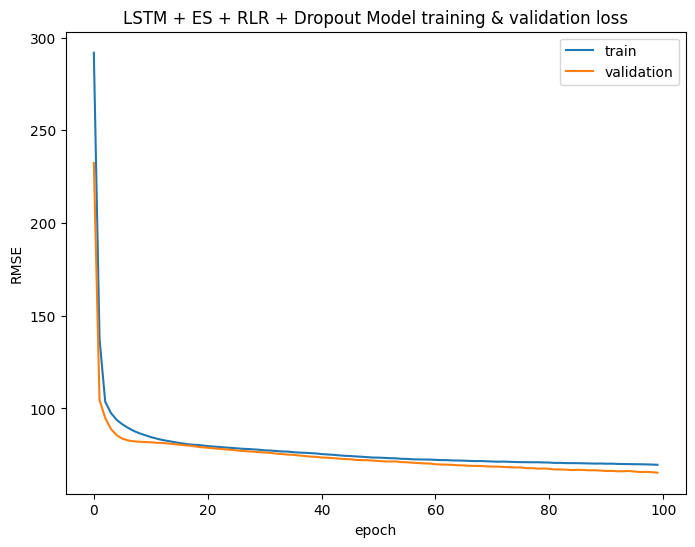

In [21]:
# Define the LSTM + Dropout model
LSTM_ES_RLR_DP_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model
LSTM_ES_RLR_DP_model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])

checkpoint_path = "LSTM_ES_RLR_DP_model/cp.ckpt"

# fit network
LSTM_ES_RLR_DP_history = LSTM_ES_RLR_DP_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path),
                                         get_reduce_learning_rate()],
                              verbose=2, shuffle=False)

test_loss, test_acc = LSTM_ES_RLR_DP_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + ES + RLR + Dropout")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_RLR_DP_history.history['loss'], label='train')
plt.plot(LSTM_ES_RLR_DP_history.history['val_loss'], label='validation')
plt.title('LSTM + ES + RLR + Dropout Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# LSTM with Early stopping Reduce Learning Rate and Dropout and Regularisation

Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_model/cp.ckpt
300/300 - 5s - loss: 288.1466 - accuracy: 0.0240 - val_loss: 213.2757 - val_accuracy: 0.0318 - lr: 0.0010 - 5s/epoch - 17ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_model/cp.ckpt
300/300 - 2s - loss: 126.5854 - accuracy: 0.3753 - val_loss: 102.7462 - val_accuracy: 0.4667 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_model/cp.ckpt
300/300 - 2s - loss: 102.1826 - accuracy: 0.0638 - val_loss: 94.2110 - val_accuracy: 2.1061e-05 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_model/cp.ckpt
300/300 - 1s - loss: 96.7801 - accuracy: 0.0410 - val_loss: 89.1394 - val_accuracy: 2.1061e-05 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 5/100

Epoch 5: saving model

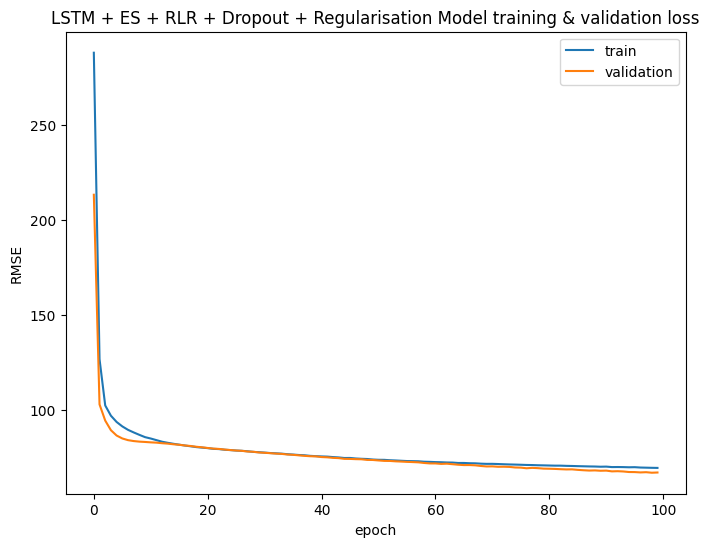

In [22]:
# Define the LSTM + Dropout model
LSTM_ES_RLR_DP_Reg_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model
LSTM_ES_RLR_DP_Reg_model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])

checkpoint_path = "LSTM_ES_RLR_DP_Reg_model/cp.ckpt"

# fit network
LSTM_ES_RLR_DP_Reg_history = LSTM_ES_RLR_DP_Reg_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path),
                                         get_reduce_learning_rate()],
                              verbose=2, shuffle=False)

test_loss, test_acc = LSTM_ES_RLR_DP_Reg_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + ES + RLR + Dropout + Regularisation")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_RLR_DP_Reg_history.history['loss'], label='train')
plt.plot(LSTM_ES_RLR_DP_Reg_history.history['val_loss'], label='validation')
plt.title('LSTM + ES + RLR + Dropout + Regularisation Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# LSTM with Early stopping Reduce Learning Rate and Dropout Batch Normalization and Regularisation

Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_BN_model/cp.ckpt
300/300 - 7s - loss: 320.6940 - accuracy: 0.4795 - val_loss: 330.7509 - val_accuracy: 0.4907 - lr: 0.0010 - 7s/epoch - 25ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_BN_model/cp.ckpt
300/300 - 2s - loss: 273.8295 - accuracy: 0.4693 - val_loss: 238.8486 - val_accuracy: 0.3278 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_BN_model/cp.ckpt
300/300 - 2s - loss: 215.8331 - accuracy: 0.4299 - val_loss: 160.4670 - val_accuracy: 0.4658 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_Reg_BN_model/cp.ckpt
300/300 - 2s - loss: 172.2582 - accuracy: 0.3646 - val_loss: 162.8826 - val_accuracy: 0.4626 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/100

Epoch 5: savin

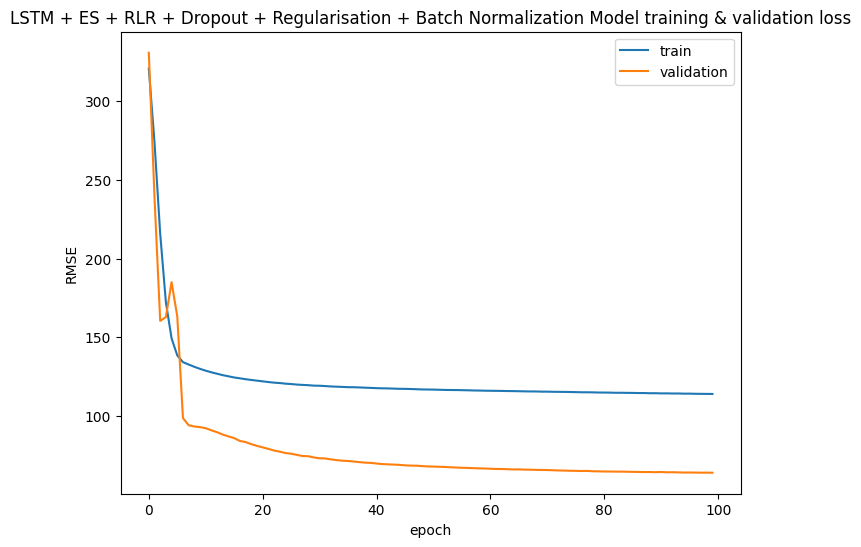

In [23]:
# Define the LSTM model
LSTM_ES_RLR_DP_Reg_BN_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model
LSTM_ES_RLR_DP_Reg_BN_model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])

checkpoint_path = "LSTM_ES_RLR_DP_Reg_BN_model/cp.ckpt"

# fit network
LSTM_ES_RLR_DP_Reg_BN_history = LSTM_ES_RLR_DP_Reg_BN_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path),
                                         get_reduce_learning_rate()],
                              verbose=2, shuffle=False)

test_loss, test_acc = LSTM_ES_RLR_DP_Reg_BN_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + ES + RLR + Dropout + Regularisation + Batch Normalization")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_RLR_DP_Reg_BN_history.history['loss'], label='train')
plt.plot(LSTM_ES_RLR_DP_Reg_BN_history.history['val_loss'], label='validation')
plt.title('LSTM + ES + RLR + Dropout + Regularisation + Batch Normalization Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# LSTM with Early stopping Reduce Learning Rate and Dropout Batch Normalization  

Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_BN_model/cp.ckpt
300/300 - 6s - loss: 320.5824 - accuracy: 0.4827 - val_loss: 331.1715 - val_accuracy: 0.4907 - lr: 0.0010 - 6s/epoch - 22ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_BN_model/cp.ckpt
300/300 - 2s - loss: 274.1460 - accuracy: 0.4746 - val_loss: 244.3682 - val_accuracy: 0.4702 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_BN_model/cp.ckpt
300/300 - 2s - loss: 215.8394 - accuracy: 0.4402 - val_loss: 158.2692 - val_accuracy: 0.4679 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_DP_BN_model/cp.ckpt
300/300 - 2s - loss: 172.9209 - accuracy: 0.3693 - val_loss: 200.7366 - val_accuracy: 0.4627 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 5/100

Epoch 5: saving model to /cont

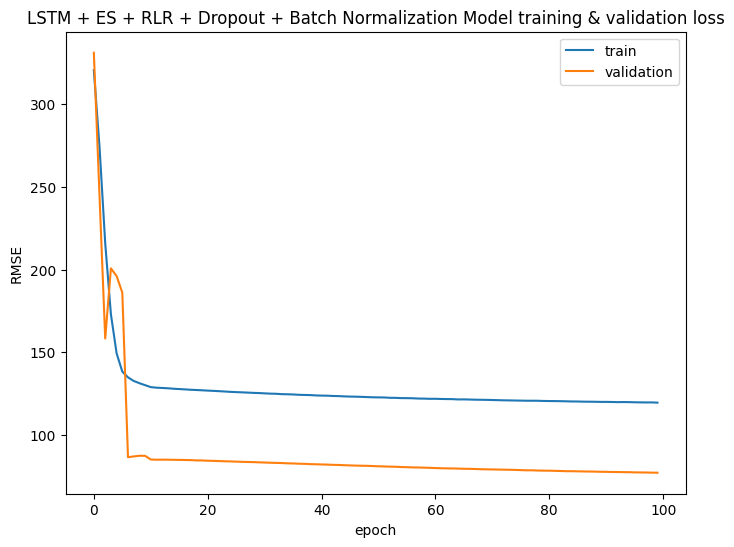

In [24]:
# Define the LSTM model
LSTM_ES_RLR_DP_BN_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model
LSTM_ES_RLR_DP_BN_model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])

checkpoint_path = "LSTM_ES_RLR_DP_BN_model/cp.ckpt"

# fit network
LSTM_ES_RLR_DP_BN_history = LSTM_ES_RLR_DP_BN_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path),
                                         get_reduce_learning_rate()],
                              verbose=2, shuffle=False)

test_loss, test_acc = LSTM_ES_RLR_DP_BN_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + ES + RLR + Dropout + Batch Normalization")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_RLR_DP_BN_history.history['loss'], label='train')
plt.plot(LSTM_ES_RLR_DP_BN_history.history['val_loss'], label='validation')
plt.title('LSTM + ES + RLR + Dropout + Batch Normalization Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

# LSTM with Early stopping Reduce Learning Rate Batch Normalization and Regularisation

Epoch 1/100

Epoch 1: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_BN_model/cp.ckpt
300/300 - 6s - loss: 319.5226 - accuracy: 0.4837 - val_loss: 329.4832 - val_accuracy: 0.4907 - lr: 0.0010 - 6s/epoch - 21ms/step
Epoch 2/100

Epoch 2: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_BN_model/cp.ckpt
300/300 - 2s - loss: 272.7623 - accuracy: 0.4754 - val_loss: 243.2626 - val_accuracy: 0.4707 - lr: 0.0010 - 2s/epoch - 8ms/step
Epoch 3/100

Epoch 3: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_BN_model/cp.ckpt
300/300 - 2s - loss: 214.5733 - accuracy: 0.4441 - val_loss: 207.9928 - val_accuracy: 0.4906 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 4/100

Epoch 4: saving model to /content/drive/MyDrive/Folsom_sky_images/LSTM_ES_RLR_Reg_BN_model/cp.ckpt
300/300 - 2s - loss: 167.4408 - accuracy: 0.3617 - val_loss: 262.0859 - val_accuracy: 0.4122 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/100

Epoch 5: saving model to /

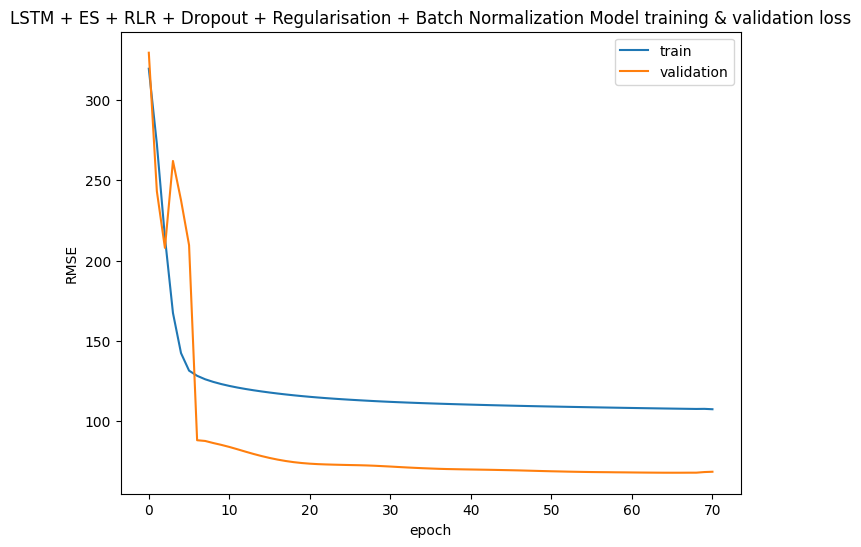

In [25]:
# Define the LSTM model
LSTM_ES_RLR_Reg_BN_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization
    tf.keras.layers.Dense(1)
])

# Compile the model
LSTM_ES_RLR_Reg_BN_model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])

checkpoint_path = "LSTM_ES_RLR_Reg_BN_model/cp.ckpt"

# fit network
LSTM_ES_RLR_Reg_BN_history = LSTM_ES_RLR_Reg_BN_model.fit(trainX, Y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(testX, Y_test),
                              callbacks=[get_early_stopping(),get_callback(checkpoint_path),
                                         get_reduce_learning_rate()],
                              verbose=2, shuffle=False)

test_loss, test_acc = LSTM_ES_RLR_Reg_BN_model.evaluate(testX, Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Performance["Model Name"].append("LSTM + ES + RLR + Regularisation + Batch Normalization")
Performance["Test Accuracy"].append(test_acc)
Performance["Test Loss"].append(test_loss)

# plot history
plt.plot(LSTM_ES_RLR_Reg_BN_history.history['loss'], label='train')
plt.plot(LSTM_ES_RLR_Reg_BN_history.history['val_loss'], label='validation')
plt.title('LSTM + ES + RLR + Dropout + Regularisation + Batch Normalization Model training & validation loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [26]:
import pandas as pd
Performance_df = pd.DataFrame(Performance)
Performance_df = Performance_df.sort_values(by=['Test Accuracy'], ascending=[False])
Performance_df


,Model Name,Test Accuracy,Test Loss
1,LSTM + Early Stopping,0.346001,34.138161
5,LSTM + ES + RLR + Dropout + Regularisation,0.324505,39.718407
3,LSTM + ES + RLR + Regularization,0.323691,37.572773
4,LSTM + ES + RLR + Dropout,0.298037,38.603107
0,Base LSTM,0.273732,37.255230
6,LSTM + ES + RLR + Dropout + Regularisation + B...,0.157965,43.317257
7,LSTM + ES + RLR + Dropout + Batch Normalization,0.156672,52.868813
2,LSTM + Early Stopping + Reduce Learning Rate,0.130692,31.883234
8,LSTM + ES + RLR + Regularisation + Batch Norma...,0.017571,51.620785


Comparing the all plots, we can see that the **LSTM model with Early Stopping, Reduce Learning Rate, Dropout and Regularization** has the best performance, with test accuracy of 32.45%. The **LSTM model with Early Stopping, Reduce Learning Rate, Dropout** has the second-best performance, with test accuracy of 29.80%.

The **LSTM model with early stopping, reduce learning rate,regularization and batch normalization**, and the **LSTM model with early stopping, reduce learning rate** have the worst performance, with test accuracies of 1.75% and 13.06% respectively.

Early stopping helps to prevent overfitting by stopping the training process when the validation loss starts to increase. Reduce learning rate helps to prevent the model from getting stuck in local minima and ensures that it finds a good solution. Dropout is a regularization technique that helps to prevent overfitting by randomly dropping out neurons during training. Regularization is a technique that helps to prevent overfitting by penalizing the model for having large weights. Batch normalization is a technique that helps to normalize the inputs to each layer of the network, which can help to improve the training process and reduce overfitting.

#### Analysis of the image
The image shows the training and validation loss for the all different LSTM models. The training loss is typically higher than the validation loss, as the model is still learning on the training data. However, the training loss should decrease over time as the model learns. The validation loss should also decrease over time, but it should not decrease as quickly as the training loss. If the validation loss starts to increase, this indicates that the model is overfitting the training data.

#### Conclusion
Based on the results of the all plots, we can conclude that the **LSTM model with Early Stopping, Reduce Learning Rate, Dropout and Regularization** has the best performance. This model has the highest test accuracy and the lowest test loss.

# Save Model (HDF5 format)

In [28]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
LSTM_ES_RLR_DP_Reg_model.save('LSTM_ES_RLR_DP_Reg_model.h5')